<a href="https://colab.research.google.com/github/NitinShindeJ/TensorFlow2.0/blob/master/My_learn_TF2.0/TF2_0_DeepLearning_TransferLearning_WithoutDataAugmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [0]:
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image

In [0]:
#Transfer Learning Imports
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
from glob import glob

In [0]:
#Data set fo Binary classification
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
#  --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip
#!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip
!wget -nc https://github.com/NitinShindeJ/TensorFlow2.0.git/Data/Food_Data.zip

In [0]:
!unzip -qq -o Food_Data.zip

In [0]:
!ls 

In [0]:
#Files in training 
!ls Food-5K/training
!mv Food-5K/* 

In [0]:
# look at an image for fun
plt.imshow(image.load_img('training/0_410.jpg'))
plt.show()

In [0]:
# Food images start with 1, non-food images start with 0
plt.imshow(image.load_img('training/1_616.jpg'))
plt.show()

In [0]:
#Making folder Data
!mkdir data

In [0]:
# Make directories to store the data Keras-style
#making folders 
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [0]:
# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [0]:
train_path = 'data/train'
valid_path = 'data/test'

In [0]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

In [0]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['Data/train/food', 'Data/train/nonfood']

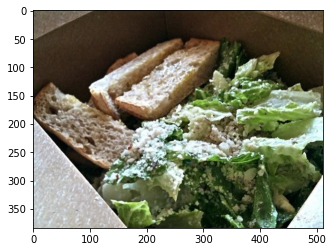

In [0]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [0]:
#VGG Model
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3], #Image size for inpput shape & [3] for color standard
    weights='imagenet',
    include_top=False) #layer upto final conv layer

In [0]:
# map the data into feature vectors
x = Flatten()(ptm.output)

In [0]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [0]:
# view the structure of the model
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

In [0]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [0]:
batch_size = 128

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary', #target is binary 
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
#transform data
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

# Figure out the output size
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros(Nvalid)

In [0]:
# populate X_train and Y_train
i = 0
for x, y in train_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_train[i:i + sz] = features
  Y_train[i:i + sz] = y
  
  # increment i
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000


In [0]:
# populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  # get features
  features = model.predict(x)
  
  # size of the batch (may not always be batch_size)
  sz = len(y)
  
  # assign to X_train and Ytrain
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y
  
  # increment i
  i += sz

  if i >= Nvalid:
    print('breaking now')
    break
print(i)

breaking now
1000


In [0]:
X_train.max(), X_train.min()

(650.8262939453125, 0.0)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [0]:
# Try the built-in logistic regression

from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2, Y_train))
print(logr.score(X_valid2, Y_valid))

1.0
0.979


In [0]:
# Do logistic regression in Tensorflow

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

In [0]:
linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [0]:
# Can try both normalized and unnormalized data
r = linearmodel.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid, Y_valid),
)

Epoch 1/10
24/24 [==============================] - 1s 22ms/step - loss: 0.7059 - accuracy: 0.9420 - val_loss: 0.2993 - val_accuracy: 0.9790
Epoch 2/10
24/24 [==============================] - 0s 14ms/step - loss: 0.0426 - accuracy: 0.9943 - val_loss: 0.3558 - val_accuracy: 0.9790
Epoch 3/10
24/24 [==============================] - 0s 13ms/step - loss: 0.0050 - accuracy: 0.9987 - val_loss: 0.3809 - val_accuracy: 0.9800
Epoch 4/10
24/24 [==============================] - 0s 11ms/step - loss: 6.7384e-04 - accuracy: 0.9997 - val_loss: 0.3386 - val_accuracy: 0.9780
Epoch 5/10
24/24 [==============================] - 0s 11ms/step - loss: 3.1967e-04 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9810
Epoch 6/10
24/24 [==============================] - 0s 12ms/step - loss: 1.5308e-06 - accuracy: 1.0000 - val_loss: 0.3206 - val_accuracy: 0.9800
Epoch 7/10
24/24 [==============================] - 0s 11ms/step - loss: 7.2721e-07 - accuracy: 1.0000 - val_loss: 0.3205 - val_accuracy: 0.98

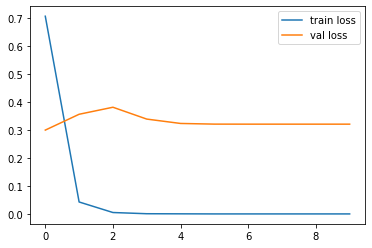

In [0]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

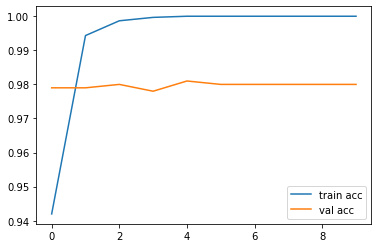

In [0]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()